In [38]:
# Import required modules
import boto3
import os
import json
import time
import matplotlib.pyplot as plt
from PIL import Image
from core_lib.math_question_generation import Analyticsfunction, mathquestion


In [39]:

# Initialize AWS services
s3 = boto3.client('s3')

# Global variable to store the summary
summary = ""

# Define S3 bucket
bucket_name = 'document-tender'

# Math question generation
math = mathquestion()

def create_image1(question):
    prompt = f'''Human: Please create a Python script to generate an informative and visually appealing image representing the mathematical concept or problem: {question}
                Please follow these guidelines:
                1. Use the seaborn package to create the plot, and save it as "image.jpg" with a resolution of 100 dpi.
                2. Ensure the code must be complete in all aspects.
                3. Ensure the image covers approximately 80% of the area, leaving space for labels.
                4. Complete all edges and align them properly for the chosen shape or representation.
                5. Label relevant components (e.g., edges, vertices, angles) with clear annotations for better understanding.
                6. Import all necessary libraries and functions required for the task.
                7. The code should be accurate, well-structured, and easy to understand.
                8. Consider using color, shading, and other visual elements to enhance the clarity and aesthetics of the image.
                Assistant:'''

    body = json.dumps({"prompt": prompt})
    text = math.call_claude_sonet_text_s35(body)
    return text


In [41]:
import time

def create_image(question):
    text2 = create_image1(question)
    
    # prompt2 = f'''Human: Check the correctness of the Python code {text}, and rewrite the updated code but don't change the important section of the code.
    #             Assistant:'''
    
    # body2 = json.dumps({"prompt": prompt2})
    
    # # Add delay of 10 seconds
    # time.sleep(10)
    
    # text2 = math.call_claude_sonet_text(body2)

    # Save code to a file
    image_name = "image.jpg"
    output_file = "main.py"
    math.extract_python_code(text2, output_file)
    
    # Execute the script
    os.system(f"python3 {output_file}")

    # Check if the image file exists
    if os.path.isfile(image_name):
        img = Image.open(image_name)
        # Upload image to S3 bucket
        s3.upload_file(image_name, bucket_name, image_name)
        image_url = f"https://{bucket_name}.s3.amazonaws.com/{image_name}"
        return img
    else:
        print(f"Error: Image file '{image_name}' not found.")
        return None

In [42]:

# Translate function
def translate(text, source_lang='en', target_lang='hi'):
    translate = boto3.client(service_name='translate', region_name='us-east-1')
    result = translate.translate_text(Text=text, SourceLanguageCode=source_lang, TargetLanguageCode=target_lang)
    return result.get('TranslatedText')

# JSON extraction function
def extract_json(response):
    try:
        start_index = response.find('{')
        end_index = response.rfind('}') + 1
        json_data = response[start_index:end_index]
        data = json.loads(json_data)
        return data
    except (ValueError, TypeError):
        print("Error: Invalid JSON data")
        return None


In [43]:
question = "ABCDEF is a hexagon (six-sided polygon). Find the value of AB+BC+CD+DE+AF+FE+AE ?"

question1 = "If the position vectors of the vertices A, B, and C of a triangle △ABC are αi+βj+γk, βi+γj+αk, and γi+αj+βk respectively, then △ABC is ?"

question2 = "What is area of rectangle?"

In [44]:

# Ask question
# question = "What is the area of a triangle?"
img = create_image(question1)


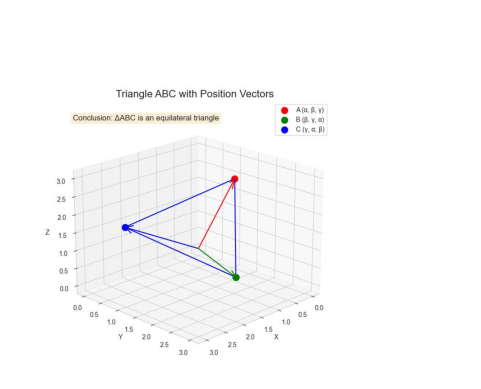

In [45]:

# Display image if exists
if img:
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [46]:

# Summarization process from uploaded text file
def summarize_text(input_file_path, target_lang='en'):
    with open(input_file_path, 'r') as file:
        text = file.read()
        
    # Summarize the text
    obj = Analyticsfunction()
    claude3 = obj.call_claude_sonet_text
    math = mathquestion()
    summary = math.create_summary(text)
    
    # Translate summary
    translated_summary = translate(summary, target_lang=target_lang)
    
    # Save the summary to file
    with open('summary.txt', 'w') as f:
        f.write(translated_summary)

    # Upload to S3
    s3.upload_file('summary.txt', bucket_name, 'summary.txt')
    summary_url = f"https://{bucket_name}.s3.amazonaws.com/summary.txt"
    
    return translated_summary


In [47]:
# For summarization, provide the file path
# input_file_path = "/Users/tiwarysa/Documents/mathimage-hackthon/document/sample1.txt" 
input_file_path = "/Users/tiwarysa/Documents/mathimage-hackthon/document/video_text.txt" 
# Replace with your local file path
summarized_text = summarize_text(input_file_path)
print(f"Summarized Text: {summarized_text}")

# Q&A based on summarized text
def generate_questions(summary, num_questions=5, target_lang='en', delay=5):
    prompt = f'''Human: Please generate {num_questions} number of multiple-choice question and their respective answers based on the content provided in the attached document. The questions should cover a range of difficulty levels (easy, medium, and hard) and test different aspects of the content, such as factual information, concepts, and analysis. Each question should have 4 answer choices, with only one correct answer. Please include question, options, answer, and explanation. 
    <book>
    {summary}
    </book>
    Please create the response in JSON format.
    Assistant:'''
    
    body = json.dumps({"prompt": prompt})
    question_data = math.question_answer_generation(body)
    json_data = extract_json(question_data)

    # Translate and display questions
    for i, question in enumerate(json_data["questions"]):
        translated_question = translate(question['question'], target_lang=target_lang)
        print(f"Question {i+1}: {translated_question}")
        img = create_image(question['question'])
        if img:
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        print(f"Options: {question['options']}")
        print(f"Answer: {question['answer']}")
        #print(f"Explanation: {translate(question['explanation'], target_lang=target_lang)}")
        print("-" * 40)
        
        # Add delay between questions
        time.sleep(delay)

Summarized Text: Here is a summary of the educational video in around 1000 words:

The video starts with the instructor introducing the topic of 3D coordinate geometry. He explains that just like in 2D coordinate geometry where points are represented using x and y coordinates, in 3D we have an additional z coordinate as well. 

He demonstrates how any point P in 3D space can be represented using its (x, y, z) coordinates. The x-coordinate represents the distance from the YZ plane, y-coordinate represents distance from XZ plane, and z-coordinate represents distance from XY plane.

The instructor then derives the distance formula between two points A(x1, y1, z1) and B(x2, y2, z2) in 3D space, which is given by √[(x2-x1)2 + (y2-y1)2 + (z2-z1)2].

He explains how this distance formula can be used to find the nature of a triangle formed by three given points - whether it is an acute angled, right angled or obtuse angled triangle based on the lengths of the sides.

For four given points, one

{
  "questions": [
    {
      "question": "What is the distance formula between two points A(x1, y1, z1) and B(x2, y2, z2) in 3D space?",
      "options": [
        "A. √[(x2-x1)^2 + (y2-y1)^2 + (z2-z1)^2]",
        "B. (x2-x1)^2 + (y2-y1)^2 + (z2-z1)^2",
        "C. (x2-x1) + (y2-y1) + (z2-z1)",
        "D. None of the above"
      ],
      "answer": "A",
      "explanation": "The distance formula between two points A(x1, y1, z1) and B(x2, y2, z2) in 3D space is derived in the video as √[(x2-x1)^2 + (y2-y1)^2 + (z2-z1)^2]."
    },
    {
      "question": "What is the condition for three points A(x1, y1, z1), B(x2, y2, z2), and C(x3, y3, z3) to be collinear in 3D space?",
      "options": [
        "A. (x1-x2)/(x2-x3) = (y1-y2)/(y2-y3) = (z1-z2)/(z2-z3)",
        "B. x1 + x2 + x3 = y1 + y2 + y3 = z1 + z2 + z3",
        "C. x1 = x2 = x3, y1 = y2 = y3, z1 = z2 = z3",
        "D. None of the above"
      ],
      "answer": "A",
      "explanation": "The condition for three points A(x1, y1, z1), B(x2, y2, z2), and C(x3, y3, z3) to be collinear in 3D space is (x1-x2)/(x2-x3) = (y1-y2)/(y2-y3) = (z1-z2)/(z2-z3), as mentioned in the video."
    },
    {
      "question": "What is the formula to find the centroid (geometric center) of a triangle with vertices A(x1, y1, z1), B(x2, y2, z2), and C(x3, y3, z3) in 3D space?",
      "options": [
        "A. ((x1+x2+x3)/3, (y1+y2+y3)/3, (z1+z2+z3)/3)",
        "B. ((x1+x2)/2, (y1+y2)/2, (z1+z2)/2)",
        "C. ((x1+x2+x3)/4, (y1+y2+y3)/4, (z1+z2+z3)/4)",
        "D. None of the above"
      ],
      "answer": "A",
      "explanation": "The formula to find the centroid (geometric center) of a triangle with vertices A(x1, y1, z1), B(x2, y2, z2), and C(x3, y3, z3) in 3D space is ((x1+x2+x3)/3, (y1+y2+y3)/3, (z1+z2+z3)/3), as mentioned in the video."
    },
    {
      "question": "What is the formula to find the mid-point M of the line segment joining two points A(x1, y1, z1) and B(x2, y2, z2) in 3D space?",
      "options": [
        "A. M((x1+x2)/2, (y1+y2)/2, (z1+z2)/2)",
        "B. M((x1+x2+x3)/3, (y1+y2+y3)/3, (z1+z2+z3)/3)",
        "C. M(x1+x2, y1+y2, z1+z2)",
        "D. None of the above"
      ],
      "answer": "A",
      "explanation": "The mid-point formula for the mid-point M of the line segment joining two points A(x1, y1, z1) and B(x2, y2, z2) in 3D space is M((x1+x2)/2, (y1+y2)/2, (z1+z2)/2), as derived in the video."
    },
    {
      "question": "What is the section formula to find the coordinates of the point R that divides the line segment AB in the ratio m1:m2 internally?",
      "options": [
        "A. R((m1*x2 + m2*x1)/(m1+m2), (m1*y2 + m2*y1)/(m1+m2), (m1*z2 + m2*z1)/(m1+m2))",
        "B. R((m1*x1 + m2*x2)/(m1+m2), (m1*y1 + m2*y2)/(m1+m2), (m1*z1 + m2*z2)/(m1+m2))",
        "C. R((x1+x2)/2, (y1+y2)/2, (z1+z2)/2)",
        "D. None of the above"
      ],
      "answer": "A",
      "explanation": "The section formula to find the coordinates of the point R that divides the line segment AB in the ratio m1:m2 internally is R((m1*x2 + m2*x1)/(m1+m2), (m1*y2 + m2*y1)/(m1+m2), (m1*z2 + m2*z1)/(m1+m2)), as discussed in the video."
    }
  ]
}

Question 1: What is the distance formula between two points A(x1, y1, z1) and B(x2, y2, z2) in 3D space?


/Users/tiwarysa/Documents/mathimage-hackthon/main.py:56: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/Users/tiwarysa/Documents/mathimage-hackthon/main.py:56: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/Users/tiwarysa/Documents/mathimage-hackthon/main.py:59: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig('image.jpg', dpi=100, bbox_inches='tight')
/Users/tiwarysa/Documents/mathimage-hackthon/main.py:59: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig('image.jpg', dpi=100, bbox_inches='tight')


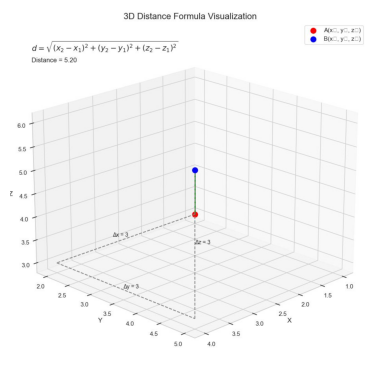

Options: ['A. √[(x2-x1)^2 + (y2-y1)^2 + (z2-z1)^2]', 'B. (x2-x1)^2 + (y2-y1)^2 + (z2-z1)^2', 'C. (x2-x1) + (y2-y1) + (z2-z1)', 'D. None of the above']
Answer: A
----------------------------------------
Question 2: What is the condition for three points A(x1, y1, z1), B(x2, y2, z2), and C(x3, y3, z3) to be collinear in 3D space?


/Users/tiwarysa/Documents/mathimage-hackthon/main.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(A[0], A[1], A[2], c=palette[0], s=100, label='A')
/Users/tiwarysa/Documents/mathimage-hackthon/main.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(B[0], B[1], B[2], c=palette[1], s=100, label='B')
/Users/tiwarysa/Documents/mathimage-hackthon/main.py:22: UserWarning: *c* argument looks like a sing

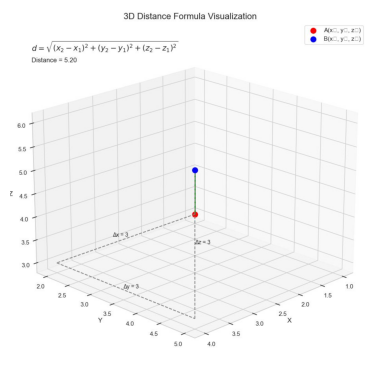

Options: ['A. (x1-x2)/(x2-x3) = (y1-y2)/(y2-y3) = (z1-z2)/(z2-z3)', 'B. x1 + x2 + x3 = y1 + y2 + y3 = z1 + z2 + z3', 'C. x1 = x2 = x3, y1 = y2 = y3, z1 = z2 = z3', 'D. None of the above']
Answer: A
----------------------------------------
Question 3: What is the formula to find the centroid (geometric center) of a triangle with vertices A(x1, y1, z1), B(x2, y2, z2), and C(x3, y3, z3) in 3D space?


/Users/tiwarysa/Documents/mathimage-hackthon/main.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


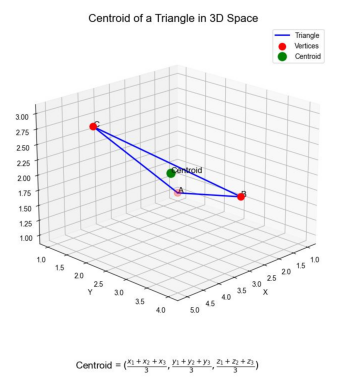

Options: ['A. ((x1+x2+x3)/3, (y1+y2+y3)/3, (z1+z2+z3)/3)', 'B. ((x1+x2)/2, (y1+y2)/2, (z1+z2)/2)', 'C. ((x1+x2+x3)/4, (y1+y2+y3)/4, (z1+z2+z3)/4)', 'D. None of the above']
Answer: A
----------------------------------------
Question 4: What is the formula to find the mid-point M of the line segment joining two points A(x1, y1, z1) and B(x2, y2, z2) in 3D space?


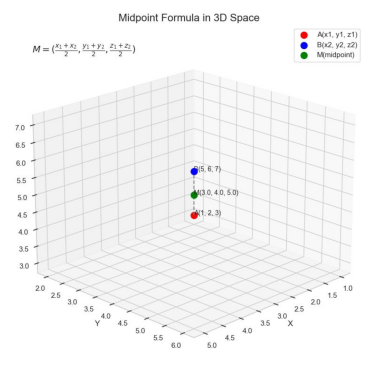

Options: ['A. M((x1+x2)/2, (y1+y2)/2, (z1+z2)/2)', 'B. M((x1+x2+x3)/3, (y1+y2+y3)/3, (z1+z2+z3)/3)', 'C. M(x1+x2, y1+y2, z1+z2)', 'D. None of the above']
Answer: A
----------------------------------------
Question 5: What is the section formula to find the coordinates of the point R that divides the line segment AB in the ratio m1:m2 internally?


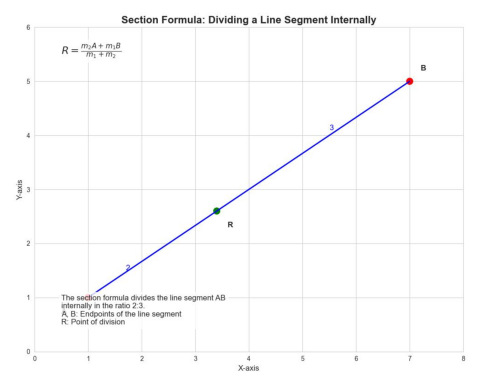

Options: ['A. R((m1*x2 + m2*x1)/(m1+m2), (m1*y2 + m2*y1)/(m1+m2), (m1*z2 + m2*z1)/(m1+m2))', 'B. R((m1*x1 + m2*x2)/(m1+m2), (m1*y1 + m2*y2)/(m1+m2), (m1*z1 + m2*z2)/(m1+m2))', 'C. R((x1+x2)/2, (y1+y2)/2, (z1+z2)/2)', 'D. None of the above']
Answer: A
----------------------------------------


In [48]:

# Call the function
generate_questions(summarized_text, num_questions=5, target_lang='en', delay=2)